In [1]:
# Importing necessary libraries
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import os
import random
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### 1. Reading and Storing Data

### Data Pre-processing

In [2]:
starttime = datetime.now()

data = open('C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/NetflixRatings.csv', mode = 'w')

In [3]:
files = ['C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_2.txt', 
         'C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_4.txt']

for file in files:
    print("Reading from file: "+str(file)+"...")
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(":"):
                movieID = line.replace(":","")
            else:
                row = []
                row = [x for x in line.split(",")]
                row.insert(0,movieID)
                data.write(",".join(row))
                data.write("\n")
                
    print("Reading of file: "+str(file)+" is completed\n")
data.close()
print("Total time taken for execution of this code = "+str(datetime.now() - starttime))

Reading from file: C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_2.txt...
Reading of file: C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_2.txt is completed

Reading from file: C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_4.txt...
Reading of file: C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/combined_data_4.txt is completed

Total time taken for execution of this code = 0:09:21.002769


In [4]:
#Creating dataframe from our output csv file
startTime = datetime.now()
Final_Data = pd.read_csv("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/NetflixRatings.csv", sep = ',',
                        names = ['MovieID','CustID','Ratings','Date'])
Final_Data['Date'] = pd.to_datetime(Final_Data['Date'])
Final_Data.sort_values(by='Date', inplace=True)
print('Time taken for execution of above code = '+str(datetime.now() - startTime))

Time taken for execution of above code = 0:02:37.525562


In [5]:
#Storing pandas dataframe as pickle file for later use
if not os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/NetflixData.pkl"):
    Final_Data.to_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/NetflixData.pkl")

In [6]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
49557332,17064,510180,2,1999-11-11
46370047,16465,510180,3,1999-11-11
22463125,8357,510180,4,1999-11-11
35237815,14660,510180,2,1999-11-11
21262258,8079,510180,2,1999-11-11


In [7]:
Final_Data.describe()['Ratings']

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [8]:
#Checking for null
print("Number of Nan values = "+str(Final_Data.isnull().sum()))

Number of Nan values = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


In [9]:
#Removing Duplicates
duplicates = Final_Data.duplicated(['MovieID','CustID','Ratings'])
print('Number of duplicate rows = '+str(duplicates.sum()))

Number of duplicate rows = 0


In [10]:
#Basic Statistics
print("Total Data:")
print("Total number of movie ratings: "+str(Final_Data.shape[0]))
print("Number of unique users: "+str(len(Final_Data['CustID'].unique())))
print("Number of unique movies: "+str(len(Final_Data['MovieID'].unique())))

Total Data:
Total number of movie ratings: 53825114
Number of unique users: 478723
Number of unique movies: 9114


In [11]:
#Splitting data into train and test (80:20)
if not os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainData.pkl")
    Train_Data = pd.read_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestData.pkl")
    Test_Data = pd.read_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

In [12]:
#Basic statistics on train data
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,17064,510180,2,1999-11-11
1,16465,510180,3,1999-11-11
2,8357,510180,4,1999-11-11
3,14660,510180,2,1999-11-11
4,8079,510180,2,1999-11-11


In [13]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(Train_Data['CustID'].unique())))
print("Number of unique movies in train data = "+str(len(Train_Data['MovieID'].unique())))
print("Highest value of User Id = "+str(max(Train_Data['CustID'].values)))
print("Highest value of Movie Id = "+str(max(Train_Data['MovieID'].values)))

Total Train Data:
Total number of movie ratings in train data = 43060091
Number of unique users in train data = 401901
Number of unique movies in train data = 8931
Highest value of User Id = 2649429
Highest value of Movie Id = 17770


In [14]:
#Basic statistics on test data
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,17405,1557557,4,2005-08-09
1,13462,2017421,4,2005-08-09
2,6475,934053,4,2005-08-09
3,6007,1156578,5,2005-08-09
4,5085,2311323,4,2005-08-09


In [15]:
print("Total Test Data:")
print("Total number of movie ratings in test data = "+str(Test_Data.shape[0]))
print("Number of unique users in test data = "+str(len(Test_Data['CustID'].unique())))
print("Number of unique movies in test data = "+str(len(Test_Data['MovieID'].unique())))
print("Highest value of User Id = "+str(max(Test_Data['CustID'].values)))
print("Highest value of Movie Id = "+str(max(Test_Data['MovieID'].values)))

Total Test Data:
Total number of movie ratings in test data = 10765023
Number of unique users in test data = 327355
Number of unique movies in test data = 9107
Highest value of User Id = 2649429
Highest value of Movie Id = 17770


## Exploratory Data Analysis on Train Data

In [16]:
def changingLabels(number):
    return str(number/10**6) + "M"

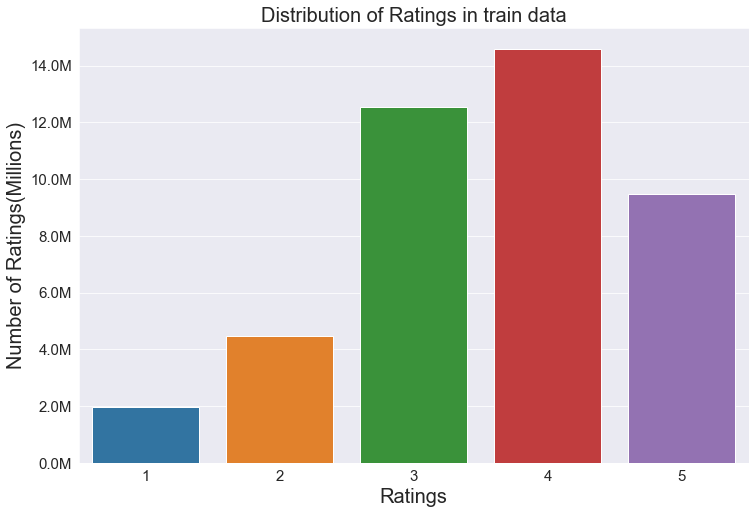

In [17]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x = 'Ratings', data = Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in train data", fontsize=20)
plt.xlabel("Ratings", fontsize=20)
plt.ylabel("Number of Ratings(Millions)", fontsize=20)
plt.show()

In [18]:
Train_Data['DayOfWeek'] = Train_Data.Date.dt.day_name()
Train_Data.tail()

,MovieID,CustID,Ratings,Date,DayOfWeek
43060086,8370,2570992,3,2005-08-09,Tuesday
43060087,17324,60769,4,2005-08-09,Tuesday
43060088,17174,1831297,4,2005-08-09,Tuesday
43060089,5765,1779412,4,2005-08-09,Tuesday
43060090,16922,1367773,5,2005-08-09,Tuesday


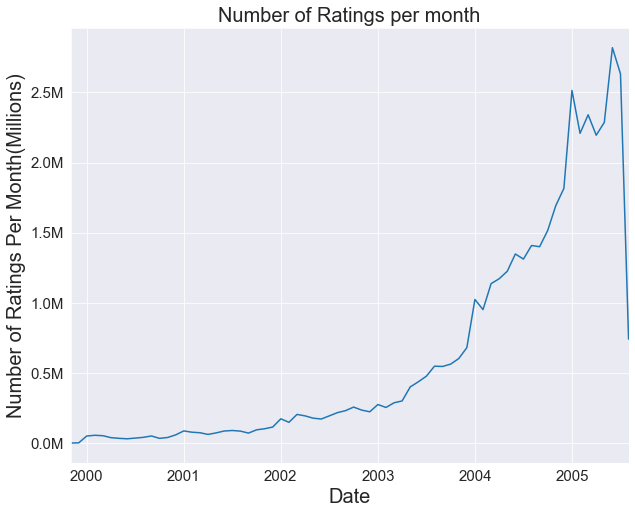

In [19]:
#Number of ratings per month
plt.figure(figsize=(10,8))
ax = Train_Data.resample("M", on="Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [20]:
#Analysis of ratings given by user
no_of_rated_movies_per_user = Train_Data.groupby(by = 'CustID')['Ratings'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

CustID
305344     8779
2439493    8126
387418     7884
1639792    4983
1461435    4846
Name: Ratings, dtype: int64

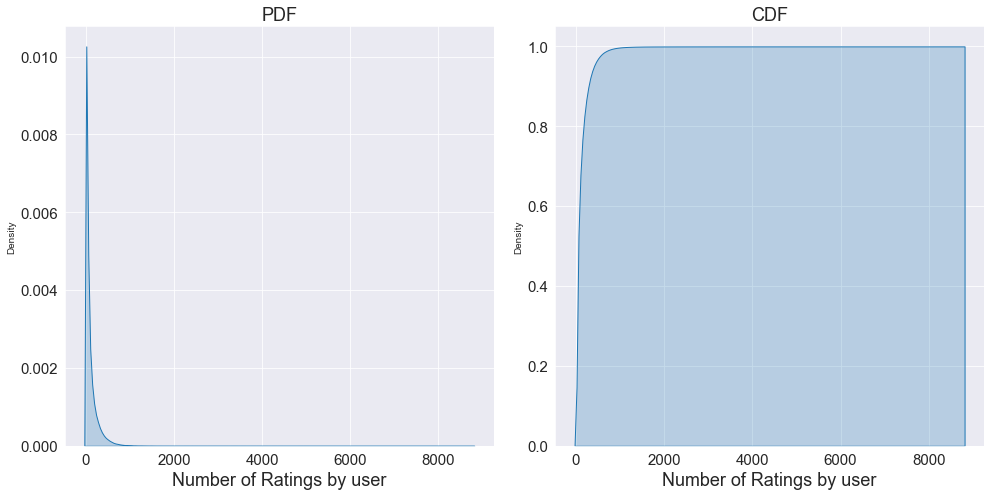

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize=18)
axes[0].set_xlabel("Number of Ratings by user", fontsize=18)
axes[0].tick_params(labelsize=15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize=18)
axes[1].set_xlabel("Number of Ratings by user", fontsize=18)
axes[1].tick_params(labelsize=15)

fig.subplots_adjust(wspace = 2)
plt.tight_layout()
plt.show()

In [22]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    401901.00000
mean        107.14104
std         155.05350
min           1.00000
25%          19.00000
50%          48.00000
75%         133.00000
max        8779.00000
Name: Ratings, dtype: float64

In [27]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

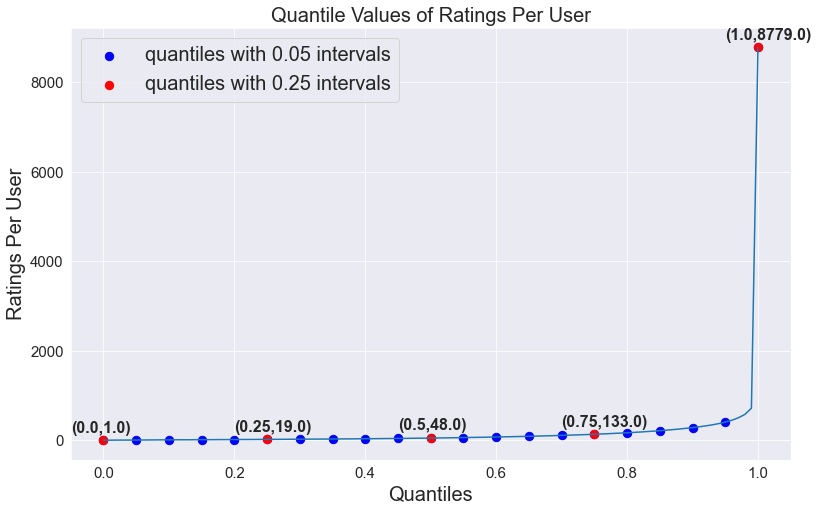

In [31]:
fig = plt.figure(figsize=(10,6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile Values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='blue', s=70, label='quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', s=70, label='quantiles with 0.25 intervals')
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x,y), xy = (x,y), fontweight='bold', fontsize=16, xytext=(x-0.05,y+180))
    
axes.tick_params(labelsize=15)

In [36]:
quantiles[::5]

0.00       1.0
0.05       4.0
0.10       8.0
0.15      12.0
0.20      15.0
0.25      19.0
0.30      23.0
0.35      27.0
0.40      33.0
0.45      40.0
0.50      48.0
0.55      59.0
0.60      72.0
0.65      88.0
0.70     108.0
0.75     133.0
0.80     166.0
0.85     213.0
0.90     281.0
0.95     404.0
1.00    8779.0
Name: Ratings, dtype: float64

In [37]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 301857
Total number of ratings above 75th percentile = 100044


In [38]:
#Analysis of ratings per movie
no_of_ratings_per_movie = Train_Data.groupby(by='MovieID')['Ratings'].count().sort_values(ascending=False)
no_of_ratings_per_movie.head()

MovieID
5317     180110
15124    177017
6287     155908
14313    154061
15205    145434
Name: Ratings, dtype: int64

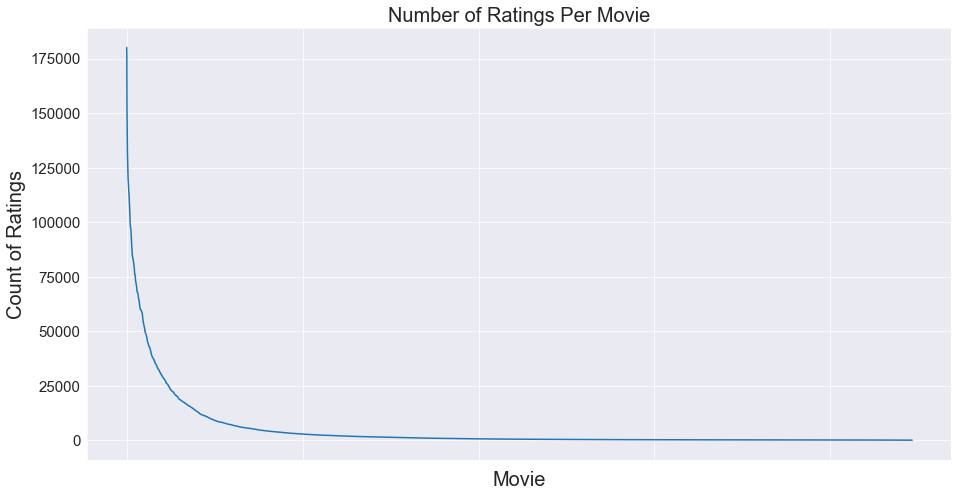

In [41]:
fig = plt.figure(figsize=(12,6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize=20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count of Ratings", fontsize=20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize=15)
axes.set_xticklabels([])
plt.show()

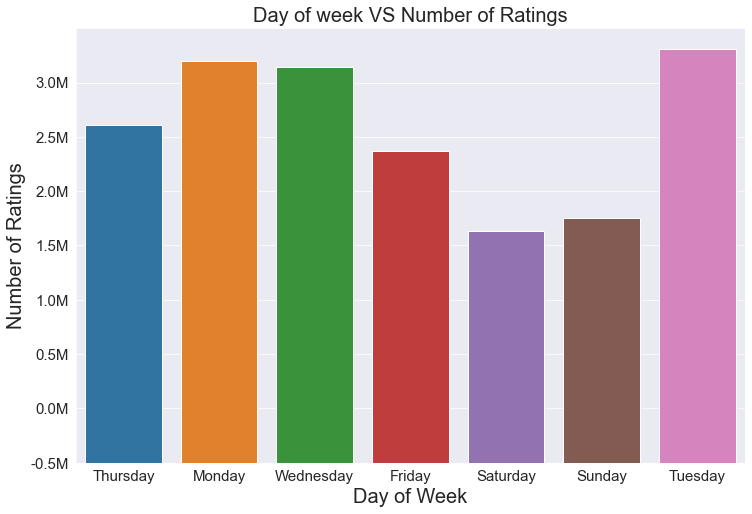

In [42]:
#Analysis of movie ratings on day of week
fig = plt.figure(figsize=(12,8))

axes = sns.countplot(x='DayOfWeek', data=Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize=20)
axes.set_xlabel("Day of Week", fontsize=20)
axes.set_ylabel("Number of Ratings", fontsize=20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize=15)

plt.show()

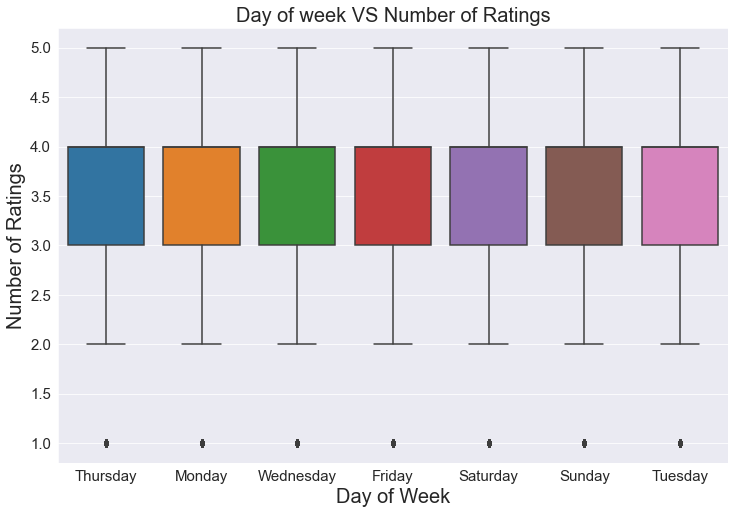

In [43]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayOfWeek", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [44]:
average_ratings_dayofweek = Train_Data.groupby(by='DayOfWeek')['Ratings'].mean()
print("Average Ratings on Day of Week")
print(average_ratings_dayofweek)

Average Ratings on Day of Week
DayOfWeek
Friday       3.589555
Monday       3.577235
Saturday     3.595120
Sunday       3.596637
Thursday     3.583570
Tuesday      3.574852
Wednesday    3.585002
Name: Ratings, dtype: float64


### 3. Creating USER-ITEM sparse matrix from data frame

In [45]:
#Creating USER-ITEM sparse matrix from data frame
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for traind data")
if os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainUISparseData.npz"):
    print("Sparse data is already present in your disk, no need to creat further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainUISparseData.npz")
    print("Shape of train sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of the matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for further usage.")
    sparse.save_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")
    
print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for traind data
We are creating sparse data
Creation done. Shape of the matrix = (2649430, 17771)
Saving it into disk for further usage.
Done

0:00:44.543695


In [46]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 17771)
Saving it into disk for furthur usage.
Done

0:00:13.074575


In [47]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity of train matrix : {}% ".format((1 - (presentElements/(rows*cols)))*100))

Sparsity of train matrix : 99.90854433187319% 


In [48]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity of test matrix : {}% ".format((1 - (presentElements/(rows*cols)))*100))

Sparsity of test matrix : 99.97713608243731% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [70]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    sumOfRatings = sparseMatrix.sum(axis = ax).A1
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [71]:
#Global average rating
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5844935859517806


In [72]:
#Average Rating per user
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [73]:
print("Average Rating of User 25 = {}".format(AvgRatingUser[25]))

Average Rating of User 25 = 3.0


In [74]:
#Averge Rating per movie
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [75]:
print("Average Rating of Movie 4500 = {}".format(AvgRatingMovie[4500]))

Average Rating of Movie 4500 = 3.28


### PDF and CDF of Average Ratings of Users and Movies

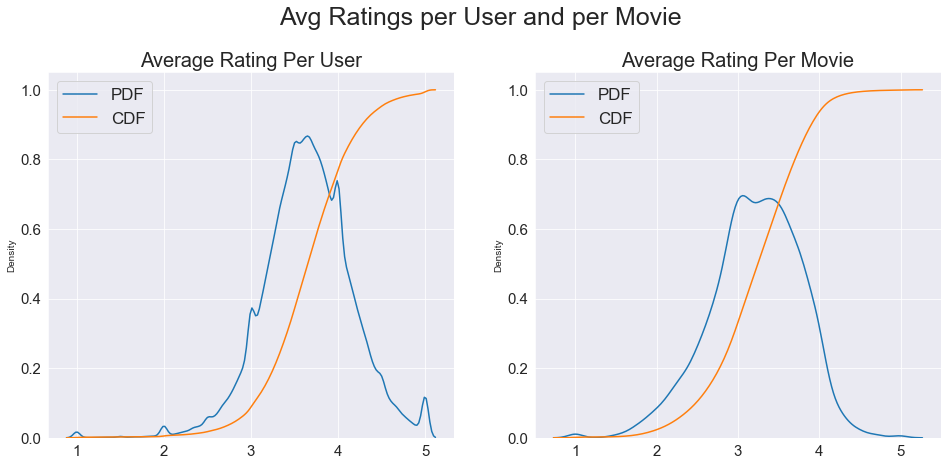

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
fig.suptitle("Avg Ratings per User and per Movie", fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist=False, ax=axes[0], label='PDF')
sns.kdeplot(user_average, cumulative=True, ax=axes[0], label='CDF')
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

In [78]:
#Cold start problems with users
total_users = len(np.unique(Final_Data['CustID']))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 478723
Number of Users in train data= 401901
Number of Users not present in train data = 76822(16.0%)


In [79]:
#Cold start problems with movies
total_movies = len(np.unique(Final_Data['MovieID']))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies

print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 9114
Number of Movies in train data= 8931
Number of Movies not present in train data = 183(2.0%)


### 4. Computing Similarity Matrices

### Computing User-User Similarity Matrix

In [80]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
25
33
42
59
79
83
87
94
97
131
134
142
149
158
168
169
178
183
188
189
192
195
199
201
242
247
248
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
470
471
477
478
479
481
485
490
491
492
495
508
515
517
527
529
536
540
544
546
550
561
576
585
592
596
602
609
614
616


In [84]:
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()
    
    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similar_Matrix = np.zeros(61700).reshape(617,100)
    timeTaken = []
    howManydone = 0
    for row in rows[:top]:
        howManydone += 1
        startTimestamp = datetime.now().timestamp()
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similar_Matrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManydone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManydone, (datetime.now() - startTimestamp20)))
    print("Average time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"Seconds")
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(timeTaken, label='Time Taken for Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Users', fontsize=20)
    plt.ylabel('Time(Seconds)', fontsize=20)
    plt.tick_params(labelsize=15)
    plt.show()
    
    return similar_Matrix

Time elapsed for 20 users = 0:01:32.859976sec
Time elapsed for 40 users = 0:02:57.337633sec
Time elapsed for 60 users = 0:04:25.794198sec
Time elapsed for 80 users = 0:05:56.650875sec
Time elapsed for 100 users = 0:07:29.475453sec
Average time taken to compute similarity matrix for 1 user = 4.441869349479675Seconds


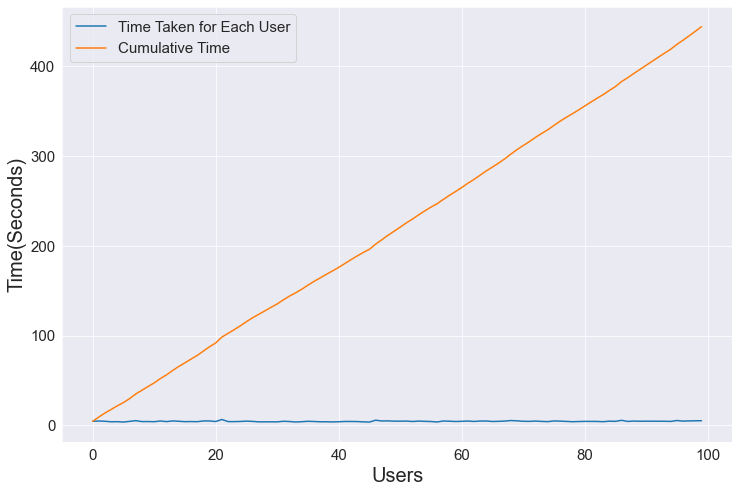

In [85]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

In [87]:
#Computing Movie-Movie Similarity Matrix
start = datetime.now()

if not os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output=False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/m_m_similarity.npz", m_m_similarity)
    
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))

print(datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Done
Dimension of Matrix = (17771, 17771)
Storing the Movie Similarity matrix on disk for further usage
0:04:28.864328


In [88]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [90]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [94]:
movie_titles_df = pd.read_csv("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/movie_titles.csv",
                             sep = ',', header=None, names=['MovieID','Year_of_Release','Movie_Title'], index_col='MovieID',
                             encoding="iso8859_2")

In [95]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [96]:
movieID_GR = 17765

print('Name of the movie ----------> '+str(movie_titles_df.loc[movieID_GR][1]))

print('Number of ratings by user for movie {} is {}'.format(movie_titles_df.loc[movieID_GR][1], 
                                                            TrainUISparseData[:,movieID_GR].getnnz()))

print('Number of similar movies {} to is {}'.format(movie_titles_df.loc[movieID_GR][1], 
                                                    m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie ----------> Godzilla's Revenge
Number of ratings by user for movie Godzilla's Revenge is 285
Number of similar movies Godzilla's Revenge to is 8863


In [97]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse=True)[1:]

similar_100 = all_similar[:101]

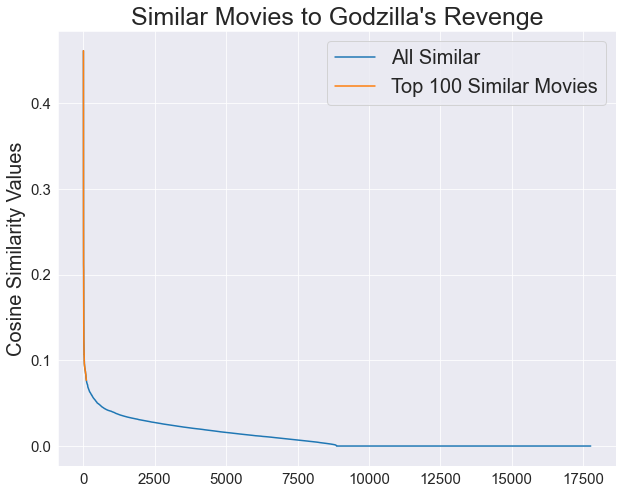

In [98]:
plt.figure(figsize=(10,8))
plt.plot(all_similar, label='All Similar')
plt.plot(similar_100, label='Top 100 Similar Movies')
plt.title("Similar Movies to Godzilla's Revenge", fontsize=25)
plt.ylabel("Cosine Similarity Values", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(fontsize=20)
plt.show()

In [100]:
movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
15810,1964.0,Godzilla vs. Mothra
5907,1956.0,Godzilla: King of the Monsters
14623,1971.0,Godzilla vs. Hedorah
8233,1968.0,Destroy All Monsters
17746,1991.0,Godzilla & Mothra: Battle for Earth / Vs. King...
15123,1995.0,Godzilla vs. Destroyah / Godzilla vs. Space Go...
8601,1997.0,Rebirth of Mothra 1 & 2: Double Feature
8656,1993.0,Godzilla vs. Mechagodzilla II
7140,2003.0,Godzilla: Tokyo S.O.S.


### 5. Machine Learning Models

In [103]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)
    userS = np.random.choice(uniq_users, n_users, replace=False)
    movieS = np.random.choice(uniq_movies, n_movies, replace=False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask],(users[mask],movies[mask])),
                                     shape=(max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path,sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

In [104]:
path = "C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2649117, 17764)
12:16:52.469619


In [105]:
path = "C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2647588, 17689)
12:21:32.278483


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [106]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((
    train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.58


### Finding Average of all movie ratings

In [107]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average movie rating for movie 14890 is {}".format(globalAvgMovies[14890]))

Average movie rating for movie 14890 is 3.2870967741935484


### Finding Average rating per User

In [110]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 16879 is {}".format(globalAvgMovies[16879]))

Average user rating for user 16879 is 3.738095238095238


### Featurizing Data

In [111]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 19214
No of ratings in Our Sampled test matrix is : 1150


### Featurizing data for regression problem

### Featurizing train data

In [112]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [113]:
if os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Train_Regression.csv", mode='w') as data:
        count = 0
        for user,movie,rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)
            row.append(movie)
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero())
            
#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            row.extend(top_similar_user_ratings)
            
#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            row.extend(top_similar_movie_ratings)
            
#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 19214 rows
Done for 2000. Time elapsed: 0:15:51.305495
Done for 4000. Time elapsed: 0:34:39.441092
Done for 6000. Time elapsed: 0:53:10.692285
Done for 8000. Time elapsed: 1:10:57.107155
Done for 10000. Time elapsed: 1:29:14.097875
Done for 12000. Time elapsed: 1:47:03.875018
Done for 14000. Time elapsed: 2:02:39.115611
Done for 16000. Time elapsed: 2:17:02.076589
Done for 18000. Time elapsed: 2:31:20.623260
Total Time for 19214 rows = 2:39:55.897691


In [114]:
Train_Reg = pd.read_csv("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Train_Regression.csv",
                       names=["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", 
                              "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4


In [116]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [117]:
print("Shape of train dataframe = "+str(Train_Reg.shape))

Shape of train dataframe = (19214, 16)


### Featurizing Test Data

In [118]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [119]:
if os.path.isfile("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Test_Regression.csv", mode='w') as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)
            row.append(movie)
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero())
            
#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                               raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 1150 rows
Done for 100. Time elapsed: 0:01:05.066327
Done for 200. Time elapsed: 0:02:00.585415
Done for 300. Time elapsed: 0:03:01.847247
Done for 400. Time elapsed: 0:03:57.714543
Done for 500. Time elapsed: 0:04:51.336197
Done for 600. Time elapsed: 0:06:05.487387
Done for 700. Time elapsed: 0:07:14.106265
Done for 800. Time elapsed: 0:07:59.522885
Done for 900. Time elapsed: 0:08:42.867671
Done for 1000. Time elapsed: 0:09:26.475573
Done for 1100. Time elapsed: 0:10:10.128675
Total Time for 1150 rows = 0:10:31.332318


In [120]:
Test_Reg = pd.read_csv("C:/Users/mbandi/Desktop/GL/Kaggle/Netflix_Recommendation/Test_Regression.csv",
                      names=["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", 
                             "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5


In [121]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


In [123]:
print("Shape of the test dataframe = {}".format(Test_Reg.shape))

Shape of the test dataframe = (1150, 16)


### Transforming Data for Surprise Models

In [124]:
Train_Reg[['User_ID','Movie_ID','Rating']].head()

,User_ID,Movie_ID,Rating
0,180921,4512,1
1,210185,4512,2
2,218038,4512,4
3,221936,4512,3
4,370736,4512,4


In [125]:
reader = Reader(rating_scale=(1,5))

data = Dataset.load_from_df(Train_Reg[['User_ID','Movie_ID','Rating']], reader)

trainset = data.build_full_trainset()

In [126]:
testset = list(zip(Test_Reg['User_ID'].values, Test_Reg['Movie_ID'].values, Test_Reg['Rating'].values))
testset[:5]

[(464626, 4614, 3),
 (1815614, 4627, 3),
 (2298717, 4627, 5),
 (2532402, 4627, 4),
 (2027, 4798, 5)]

In [127]:
error_table = pd.DataFrame(columns=['Model','Train RMSE','Train MAPE','Test RMSE','Test MAPE'])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [128]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], 
                                                  columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop=True, inplace=True)

In [136]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true)) * 100
    return rmse, mape

In [137]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [138]:
def plot_importance(model, clf):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax=ax, height=0.3)
    plt.xlabel("F Score", fontsize=20)
    plt.ylabel("Features", fontsize=20)
    plt.title("Feature Importance", fontsize=20)
    plt.tick_params(labelsize=15)
    
    plt.show()

In [139]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [140]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [146]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

### 1. XGBoost 13 Features

[19:59:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.605147450764408
MAPE = 16.54796668390486
--------------------------------------------------
TEST DATA
RMSE = 1.122648712758037
MAPE = 32.010038321260296
--------------------------------------------------
Time Taken = 0:00:01.689002


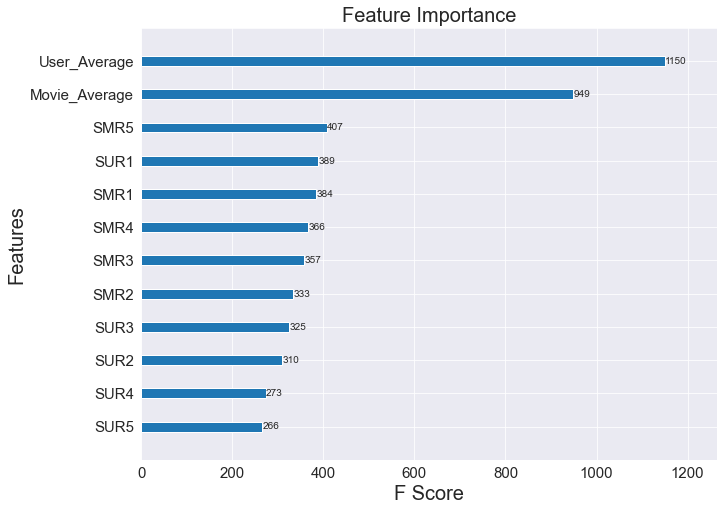

In [142]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis=1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis=1)

y_train = Train_Reg['Rating']

y_test = Test_Reg['Rating']

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation['XGBoost_13'] = train_result
model_test_evaluation['XGBoost_13'] = test_result

### 2. Surprise BaselineOnly Model

In [147]:
bsl_options = {'method':'sgd', 'learning_rate':0.01, 'n_epochs':25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, 'BaselineOnly')

model_train_evaluation['BaselineOnly'] = train_result
model_test_evaluation['BaselineOnly'] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8811426214928658
MAPE = 27.158727146074078
--------------------------------------------------
TEST DATA
RMSE = 1.0678388468431512
MAPE = 33.39729060309592
--------------------------------------------------
Time Taken = 0:00:00.245398


### 3. XGBoost 13 Features + Surprise BaselineOnly Model

### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [148]:
Train_Reg['BaselineOnly'] = model_train_evaluation['BaselineOnly']['Prediction']

In [149]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1,2.077166
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2,2.916411
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4,2.905264
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3,3.290933
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4,3.561135


In [150]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [151]:
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804


In [152]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


[20:13:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5949516727256533
MAPE = 16.334636401308618
--------------------------------------------------
TEST DATA
RMSE = 1.256248231372438
MAPE = 30.663328750927953
--------------------------------------------------
Time Taken = 0:00:01.929862


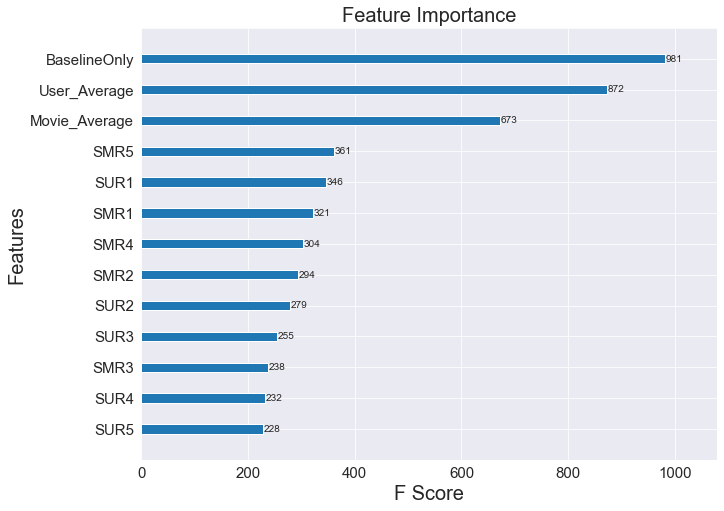

In [153]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

# 4. Surprise KNN-Baseline with User-User and Item-Item Similarity

### 4.1 Surprise KNN-Baseline with User-User.

#### Cross Validation

In [154]:
param_grid = {'sim_options':{'name':['pearson_baseline'], 'user_based': [True], 'min_support': [2], 'shrinkage': [60,80,80,140]},
             'k': [5,20,40,80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse','mae'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### Applying KNNBaseline User-User with best parameters

In [155]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3044975188091617
MAPE = 8.090955152033715
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:20.469913


### 4.2 Surprise KNN-Baseline with Item-Item.

####  Cross Valdation

In [156]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 
               'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### Applying KNNBaseline Item-Item with best parameters

In [157]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.18165138844472184
MAPE = 4.245794665995157
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:01.672042


### 5. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline

#### Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe

In [158]:
Train_Reg["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

Test_Reg["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [159]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1,2.077166,1.193482,1.076235
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2,2.916411,2.246199,2.014904
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4,2.905264,3.727792,3.653776
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3,3.290933,3.097569,2.961074
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4,3.561135,3.042586,3.105870


In [160]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [161]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804


In [162]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


[20:43:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.588477595793001
MAPE = 16.365733390393007
--------------------------------------------------
TEST DATA
RMSE = 1.146172458703426
MAPE = 31.64374058177516
--------------------------------------------------
Time Taken = 0:00:01.920909


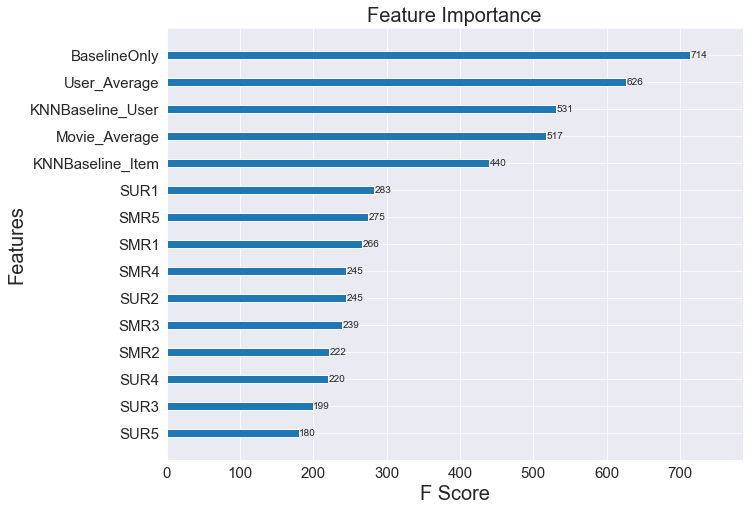

In [163]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

### 6. Matrix Factorization SVD

#### Cross Validation

In [165]:
param_grid = {'n_factors':[5,7,10,15,20,25,35,50,70,90]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

0.9943509462878898
{'n_factors': 5}


### Applying SVD with best parameters

In [166]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.897474079830485
MAPE = 28.132679472173738
--------------------------------------------------
TEST DATA
RMSE = 1.0676622377238296
MAPE = 33.39872287183235
--------------------------------------------------
Time Taken = 0:00:00.560504


### 7. Matrix Factorization SVDpp with implicit feedback

#### Cross Validation

In [167]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9820611899300172
{'n_factors': 10, 'lr_all': 0.006}


### Applying SVDpp with best parameters

In [168]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7981372223890375
MAPE = 24.51136923317255
--------------------------------------------------
TEST DATA
RMSE = 1.0675966174670914
MAPE = 33.39766876721484
--------------------------------------------------
Time Taken = 0:00:06.747609


# 8. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [169]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [170]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,...,2.0,2.0,2.900000,2.5,1,2.077166,1.193482,1.076235,2.234755,2.244995
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,...,4.0,4.0,3.388889,2.5,2,2.916411,2.246199,2.014904,3.060441,2.798540
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,...,3.0,5.0,4.250000,2.5,4,2.905264,3.727792,3.653776,3.024390,2.995288
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,...,5.0,3.0,3.458333,2.5,3,3.290933,3.097569,2.961074,3.437349,3.464333
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,...,4.0,5.0,4.038462,2.5,4,3.561135,3.042586,3.105870,3.775050,3.631253


In [171]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [172]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804,3.582804,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804,3.582804,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804,3.582804,3.582804


In [173]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


[21:00:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5873849065080787
MAPE = 16.42701877662427
--------------------------------------------------
TEST DATA
RMSE = 1.1408603176326593
MAPE = 31.697238894476172
--------------------------------------------------
Time Taken = 0:00:03.516137


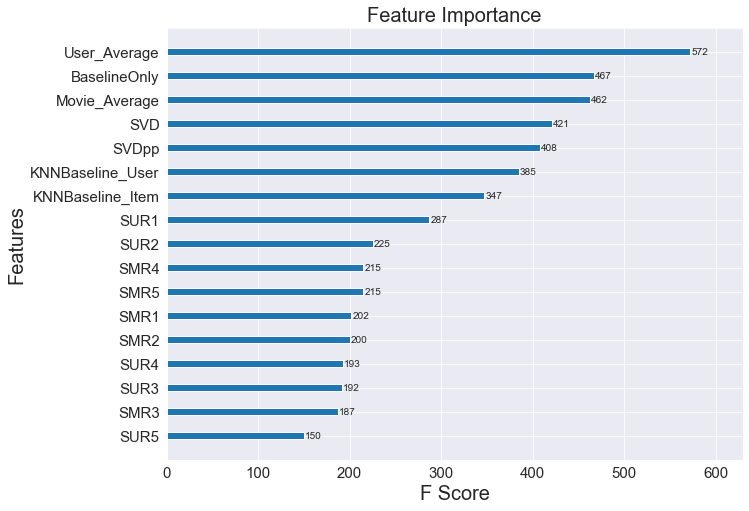

In [174]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

### 9. Surprise KNN Baseline + SVD + SVDpp

[21:01:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.9200401795110005
MAPE = 29.57733252694898
--------------------------------------------------
TEST DATA
RMSE = 1.1014591872021013
MAPE = 32.509117427425004
--------------------------------------------------
Time Taken = 0:00:01.587289


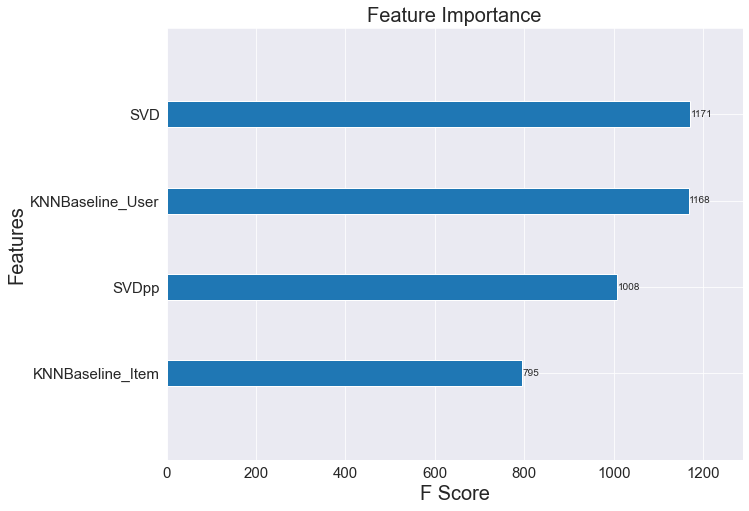

In [175]:
x_train = Train_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

x_test = Test_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF")

model_train_evaluation["XGB_KNN_MF"] = train_result
model_test_evaluation["XGB_KNN_MF"] = test_result

In [176]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

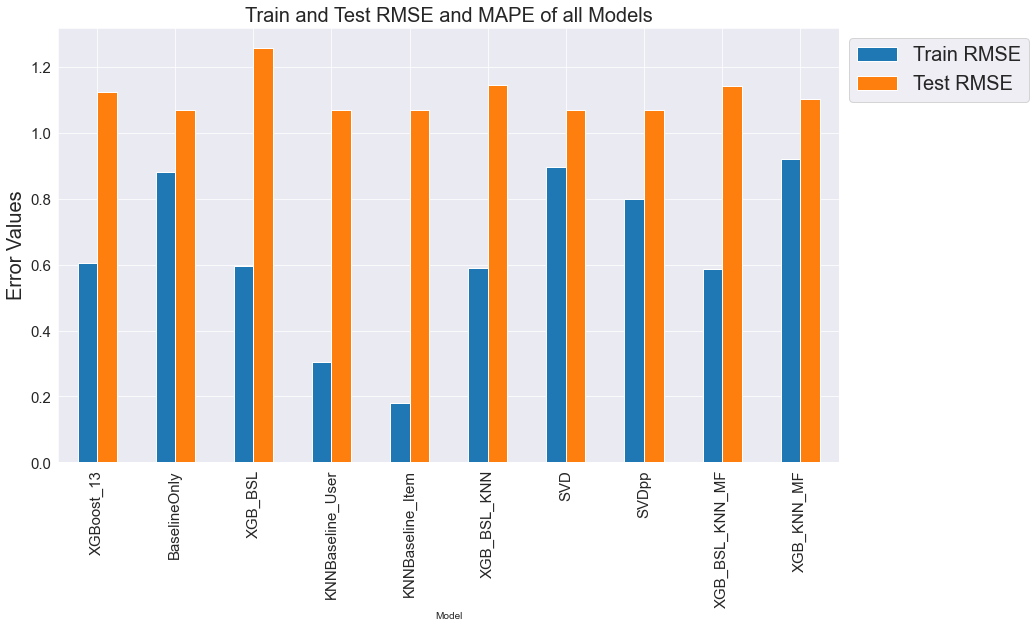

In [177]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [178]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.605147,1.122649
1,BaselineOnly,0.881143,1.067839
2,XGB_BSL,0.594952,1.256248
3,KNNBaseline_User,0.304498,1.067655
4,KNNBaseline_Item,0.181651,1.067655
5,XGB_BSL_KNN,0.588478,1.146172
6,SVD,0.897474,1.067662
7,SVDpp,0.798137,1.067597
8,XGB_BSL_KNN_MF,0.587385,1.140860
9,XGB_KNN_MF,0.920040,1.101459
